In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transforms for the data
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
# Download and load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Download and load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Define the classes for CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# visualize some of the training images
batch_size = 128

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)


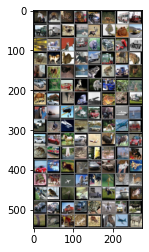

horse dog   frog  dog   car   deer  truck truck truck truck cat   ship  deer  bird  frog  car   car   horse cat   truck dog   car   truck truck deer  dog   cat   dog   truck truck deer  frog  dog   deer  cat   ship  frog  dog   truck deer  car   deer  plane horse horse car   frog  deer  horse car   bird  truck plane frog  frog  truck horse ship  plane truck car   horse ship  ship  truck cat   ship  deer  car   dog   plane truck car   car   horse car   plane bird  deer  car   frog  ship  ship  cat   truck deer  ship  dog   car   plane dog   deer  car   car   dog   plane frog  horse plane plane dog   bird  cat   deer  truck bird  bird  bird  truck horse ship  frog  car   truck truck truck frog  horse car   deer  bird  bird  deer  frog  deer  horse plane horse


In [6]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
# Define the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
class DenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.BatchNorm2d(160),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = self.conv(x)
        out = self.block1(x)
        x = torch.cat([x, out], 1)
        out = self.block2(x)
        x = torch.cat([x, out], 1)
        out = self.block3(x)
        x = torch.cat([x, out], 1)
        out = self.block4(x)
        x = torch.cat([x, out], 1)
        out = self.avgpool(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [10]:
model = DenseNet()

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)
to_device(model, device);

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
model = to_device(DenseNet(), device)

In [16]:
evaluate(model, testloader)

{'val_loss': 2.295783758163452, 'val_acc': 0.08445411175489426}

In [17]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [18]:
import time
start_time = time.time()

In [19]:
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

Epoch [0], train_loss: 1.5777, val_loss: 1.3930, val_acc: 0.4876
Epoch [1], train_loss: 1.2084, val_loss: 1.1688, val_acc: 0.5816
Epoch [2], train_loss: 1.0526, val_loss: 1.3669, val_acc: 0.5391
Epoch [3], train_loss: 0.9576, val_loss: 1.0771, val_acc: 0.6269
Epoch [4], train_loss: 0.8883, val_loss: 1.0488, val_acc: 0.6273
Epoch [5], train_loss: 0.8352, val_loss: 0.9644, val_acc: 0.6638
Epoch [6], train_loss: 0.7848, val_loss: 1.0791, val_acc: 0.6295
Epoch [7], train_loss: 0.7446, val_loss: 0.9536, val_acc: 0.6879
Epoch [8], train_loss: 0.7067, val_loss: 0.8976, val_acc: 0.6867
Epoch [9], train_loss: 0.6776, val_loss: 0.7628, val_acc: 0.7299


In [20]:
elapsed_time = time.time() - start_time
elapsed_time

177.67993783950806

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

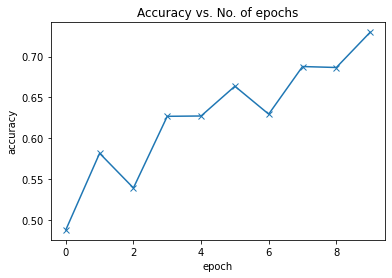

In [22]:
plot_accuracies(history)

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

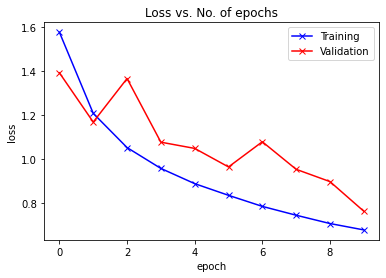

In [24]:
plot_losses(history)

In [25]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

Total Trainable Params: 210634


210634